In [1]:
import sys
import os
sys.path.append('..')

# Load/Prepare model

In [2]:
import torch
from comic_ocr.models import localization
from comic_ocr.utils import get_path_project_dir
from comic_ocr.utils.pytorch_model import get_total_parameters_count

model_path = get_path_project_dir('data/output/models/localization.bin')
model = localization.create_new_model()

def save_model(model, model_path):
    torch.save(model, model_path)


print(f'Training [{model_path}] from scratch')

print('- preferred_image_size:', model.preferred_image_size)
print('- get_total_parameters_count', get_total_parameters_count(model))
print('- model', model)

Training [/Users/wanasit/Dropbox/Workspace_Personal/manga-ocr/notebooks/../comic_ocr/utils/../../data/output/models/localization.bin] from scratch
- preferred_image_size: (500, 500)
- get_total_parameters_count 197602
- model ConvUnet(
  (down_conv_3): ConvWithPoolingToHalfSize(
    (conv): Sequential(
      (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (down_conv_2): ConvWithPoolingToHalfSize(
    (conv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (down_conv_1): ConvWithPoolingToHalfSize(
    (conv): Sequential(


## Load/Prepare Dataset

In [3]:
from comic_ocr.models.localization.localization_dataset import LocalizationDataset
from comic_ocr.utils.ploting import show_images

dataset_generated 2408


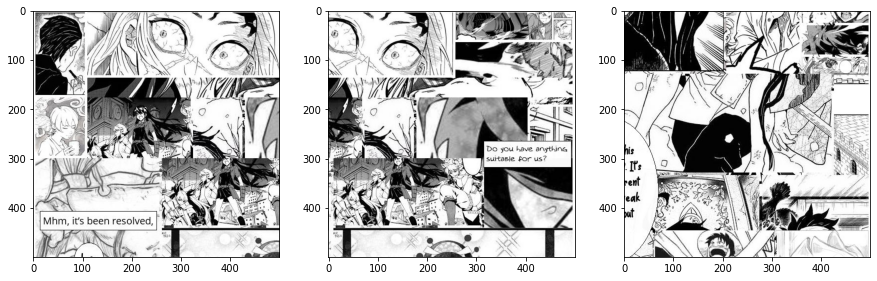

In [4]:
dataset_generated_path = get_path_project_dir('data/output/generate_manga_dataset')
dataset_generated = LocalizationDataset.load_generated_manga_dataset(
    dataset_generated_path, image_size=model.preferred_image_size)

print('dataset_generated', len(dataset_generated))
show_images([
    dataset_generated.get_image(0), 
    dataset_generated.get_image(1), 
    dataset_generated.get_image(-1)
])

dataset_annotated 140


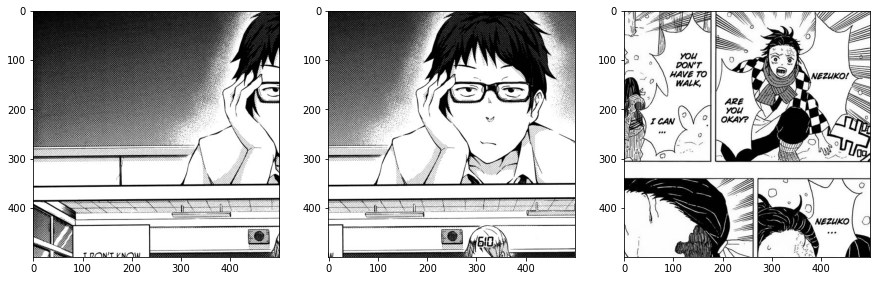

In [5]:
dataset_annotated_path = get_path_project_dir('data/manga_line_annotated')
dataset_annotated = LocalizationDataset.load_line_annotated_manga_dataset(
    dataset_annotated_path, image_size=model.preferred_image_size)

print('dataset_annotated', len(dataset_annotated))

show_images([
    dataset_annotated.get_image(0), 
    dataset_annotated.get_image(1), 
    dataset_annotated.get_image(-5)
])

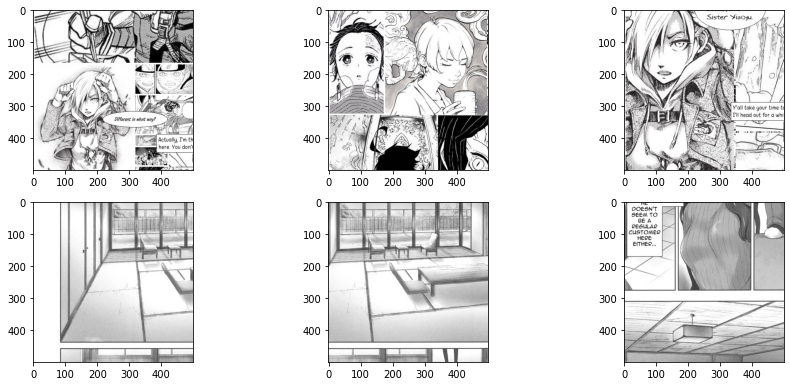

validation_dataset 100
training_dataset 1540


In [6]:
import random
random.seed('abc')
dataset_annotated = dataset_annotated.shuffle()
dataset_generated = dataset_generated.shuffle()


show_images([
    dataset_generated.get_image(0),
    dataset_generated.get_image(1),
    dataset_generated.get_image(2),
    dataset_annotated.get_image(0), 
    dataset_annotated.get_image(1), 
    dataset_annotated.get_image(2),
])

validation_dataset = LocalizationDataset.merge(
    dataset_generated.subset(to_idx=90),
    dataset_annotated.subset(to_idx=10))

training_dataset = LocalizationDataset.merge(
    dataset_generated.subset(from_idx=90, to_idx=1500),
    dataset_annotated.subset(from_idx=10)
).shuffle()

print('validation_dataset', len(validation_dataset))
print('training_dataset', len(training_dataset))

# Training

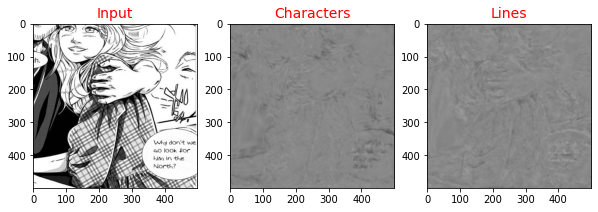

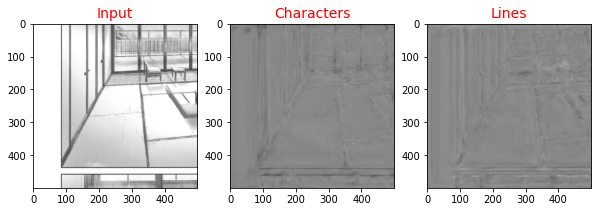

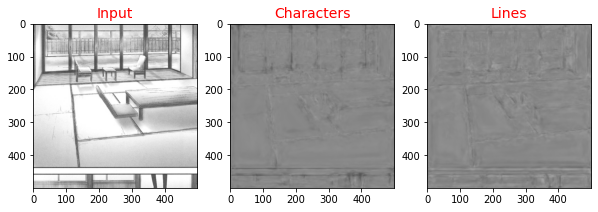

In [7]:
from comic_ocr.utils.ploting import plot_losses, show_images
from IPython.display import clear_output

def show_example(model, img):
    mask_char, mask_line = model.create_output_marks(img)
    show_images(
        images=[img, mask_char, mask_line], 
        texts=['Input', 'Characters', 'Lines'], 
        figsize=(10, 10), num_col=3
    )

show_example(model, training_dataset.get_image(0))
show_example(model, dataset_annotated.get_image(0))
show_example(model, dataset_annotated.get_image(1))

In [8]:
def save_and_report(i_epoch, train_losses, val_losses):
    clear_output()
    plot_losses(train_losses, val_losses)
    show_example(model, training_dataset.get_image(0))
    show_example(model, dataset_annotated.get_image(0))
    show_example(model, dataset_annotated.get_image(1))
    
    torch.save(model, model_path)

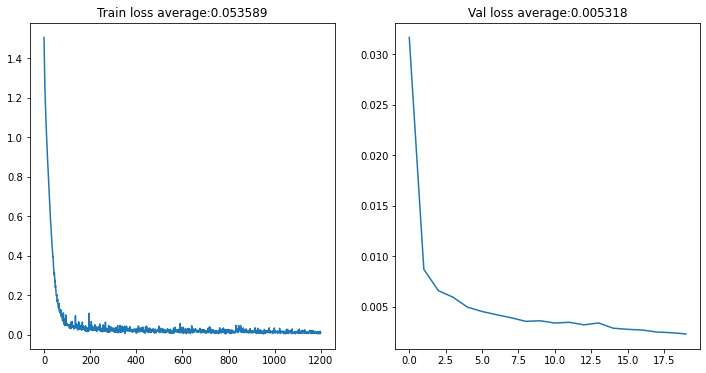

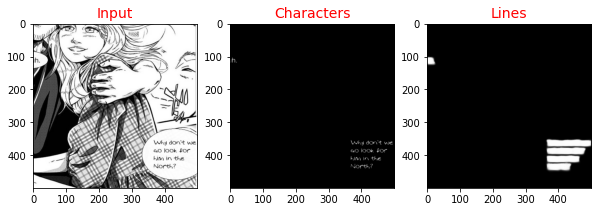

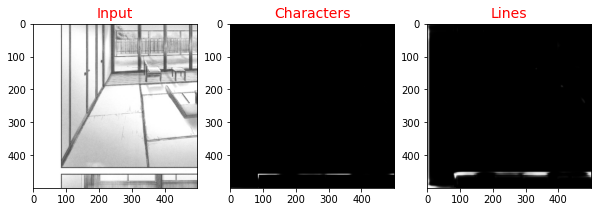

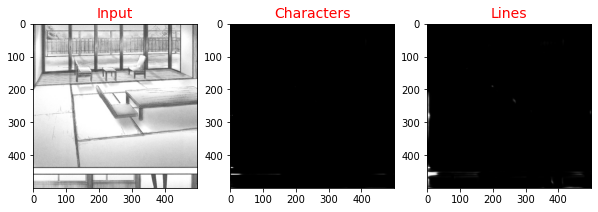

Epoch 3: 100%|█████████████████████| 1540/1540 [21:03<00:00,  1.22it/s, train_loss=0.00265, validate_loss=0.00228]


In [9]:
from comic_ocr.models.localization.train import train
_ = train(model,
          train_dataset=training_dataset,
          validate_dataset=validation_dataset,
          validate_every_n=300,
          update_callback=save_and_report,
          update_every_n=300,
          batch_size=5,
          epoch_count=4)